In [3]:
# import libraries
from pprint import pprint
import importlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import matplotlib.animation as animation
from datetime import timedelta
import geopandas as gpd
import matplotlib.animation as animation
from PIL import Image
import io
from datetime import datetime
from owid import catalog

# my function
import plotting as pl

# Variables
cat = catalog.find(namespace="covid")
tb1 = cat.iloc[1].load()  # create a table from the first dataset
world = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

Processing dates: 100%|██████████████████████████████████████████████████████████████| 32/32 [00:36<00:00,  1.14s/date]


Animation saved as covid_cases_animation.gif


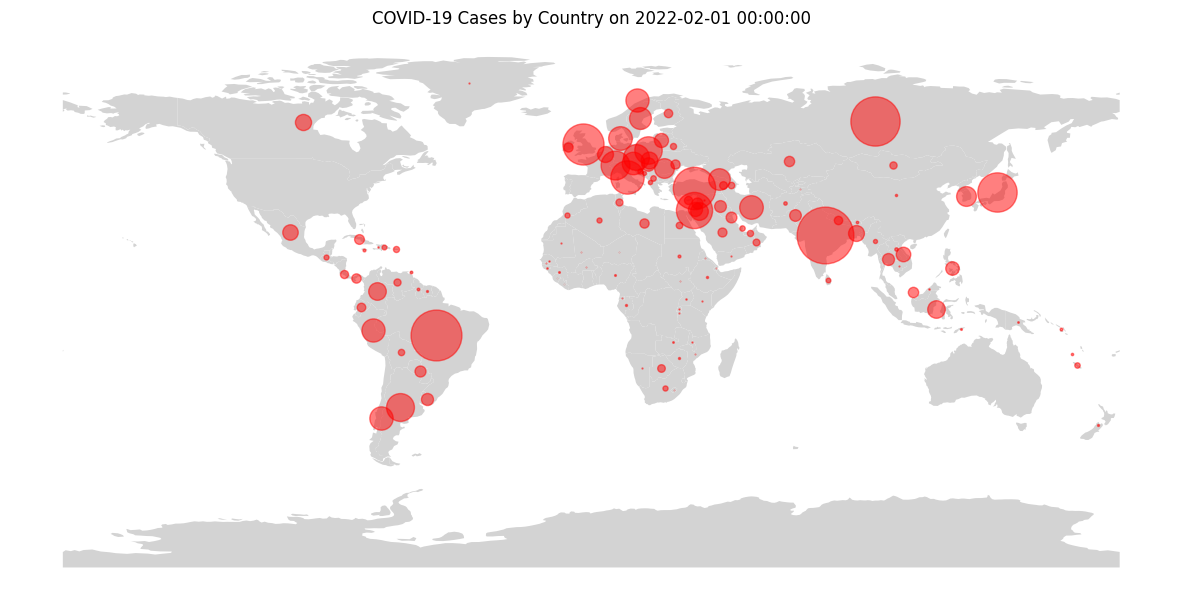

In [39]:
# Functions
# --------------------------------
importlib.reload(pl)
# pl.disp_catalogue_info(cat)  # show datasets in catalogue
# pl.plot_cases_deaths_by_country(tb1, 'Austria', None)  # cases and deaths over time of a country

fig, ax = plt.subplots(figsize=(15, 10))
# world_fig = pl.plot_world_map_with_circles(fig, ax, tb1, world, "2022-01-01", True) # plot world cases on some date.
pl.create_world_map_cases_animation(fig, ax, tb1, world, 'covid_cases_animation.gif')